### General rules:
 * Replace *Template* by your *FirstnameLastname* in the filename before submitting the solution.
 * For all figures that you generate, remember to add meaningful labels to the axes, and make a legend, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.

# AAND - BCI Exercise Sheet #01

#### Name: Laura Freire Lyra

In [1]:
# This is just a suggestion. You can do it your way.

%matplotlib inline

import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt

import bci_minitoolbox as bci

## Load the data set

In [2]:
fname= 'eyes_closed_VPal.npz'
X, fs, clab, mnt = bci.load_data(fname)

## Exercise 1: PCA on raw data  (2 points)
Make a scatter plot using the channels Fz and Oz. Visualize the complete covariance matrix (functions `np.cov` and `pl.imshow`). Then determine the two principle components (Eigenvectors) (function `np.linalg.eigh`) of that data that correspond to the largest Eigenvalues and display them as scalp maps (function `scalpmap` provided in the `bci_minitoolbox`).

In [3]:
def principal_components(data):
    """
    gets data were the rows are different channels
    return: covariance matrix, sorted eigenvalues and eigenvectors IN COLUMNS 
    in ascending order
    """
    
    cov_matrix = np.cov(data)
    
    eigenval, eigenvec = np.linalg.eigh(cov_matrix)
    
    return cov_matrix, eigenval, eigenvec 

In [4]:
selected_channels = ['Fz', 'Oz']
idx = [clab.index(x) for x in selected_channels]
print('\nThe indices of the selected channels are:')
print(idx)


The indices of the selected channels are:
[17, 112]


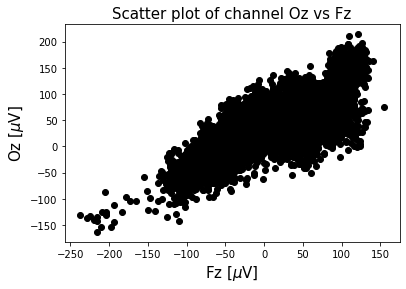

In [5]:
plt.scatter(X[17],X[112], color = "black")
plt.title("Scatter plot of channel Oz vs Fz", fontsize = 15)
plt.xlabel("Fz [$\mu$V]", fontsize = 15)
plt.ylabel("Oz [$\mu$V]", fontsize = 15);

In [6]:
cov_matrix, eigenval, eigenvec = principal_components(X)

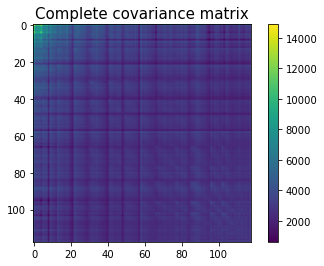

In [7]:
plt.imshow(cov_matrix)
plt.colorbar()
plt.title("Complete covariance matrix", fontsize = 15);

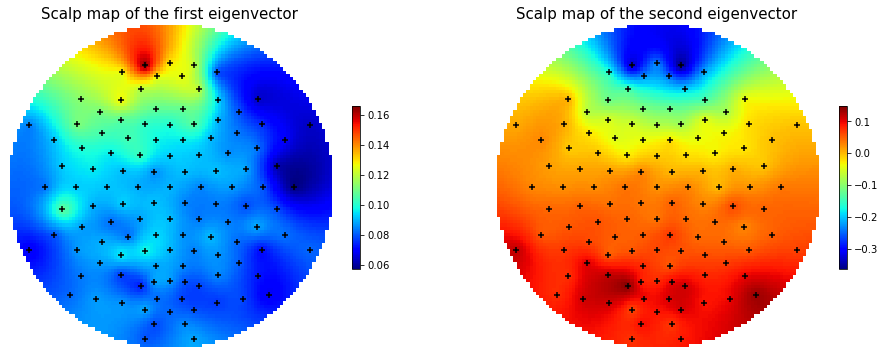

In [8]:
fig = plt.figure(figsize = (16,6))

fig.add_subplot(121)
plt.title("Scalp map of the first eigenvector", fontsize = 15)
bci.scalpmap(mnt,eigenvec.T[-1])

fig.add_subplot(122)
plt.title("Scalp map of the second eigenvector", fontsize = 15)
bci.scalpmap(mnt,eigenvec.T[-2])

## Exercise 2: Artifact Correction with PCA  (3 points)
Using the backward model, estimate the source activity corresponding to the two components that were found in Ex. \#01 and plot the two obtained time series. Using the forward model, estimate that part of the measured EEG signals, that originates from these two sources. Subtract this multivariate signal from the original EEG. Compare the thus obtained cleaned signal in channel Fz with the original data.

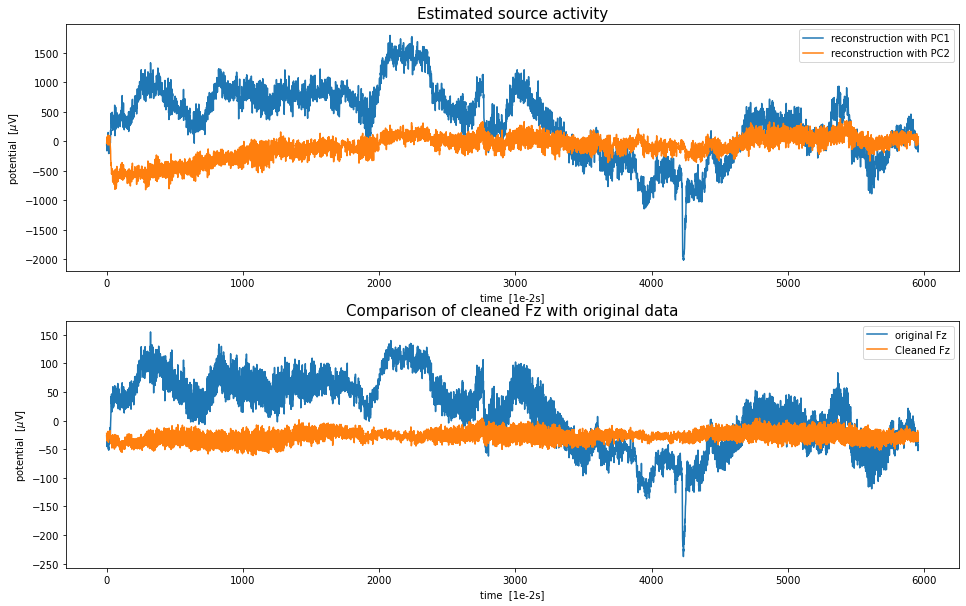

In [9]:
pcs = np.vstack((eigenvec.T[-1],eigenvec.T[-2])).T

#backward model
sources = pcs.T @ X

#forward model
recons_x = pcs @ sources
x_subtract = X - recons_x

#plotting
fig, axs = plt.subplots(2,1,figsize = (16,10))

axs[0].plot(sources[0], label = "reconstruction with PC1")
axs[0].plot(sources[1], label = "reconstruction with PC2")
axs[0].set_title("Estimated source activity", fontsize = 15)
axs[0].legend()
axs[0].set_xlabel('time  [1e-2s]')
axs[0].set_ylabel('potential  [$\mu$V]')

axs[1].plot(X[17], label ="original Fz")
axs[1].plot(x_subtract[17], label = "Cleaned Fz")
axs[1].legend()
axs[1].set_xlabel('time  [1e-2s]')
axs[1].set_title("Comparison of cleaned Fz with original data", fontsize = 15)
axs[1].set_ylabel('potential  [$\mu$V]');

## Exercise 3: PCA on band-pass filtered data (3 points)
Design a butterworth band-pass filter of order 10 with the frequency band 8-12 Hz (function `sp.signal.butter`). Apply that band-pass filter to the original EEG signals (function `sp.signal.lfilter`) and compare raw and filtered signals for channel Oz.
Visualize the covariance matrix of the filtered data and check the eigenvalue spectrum, to determine how many strong principal components there are. Visualize those principal components as in Ex. \#01. Compare the results and discuss shortly.

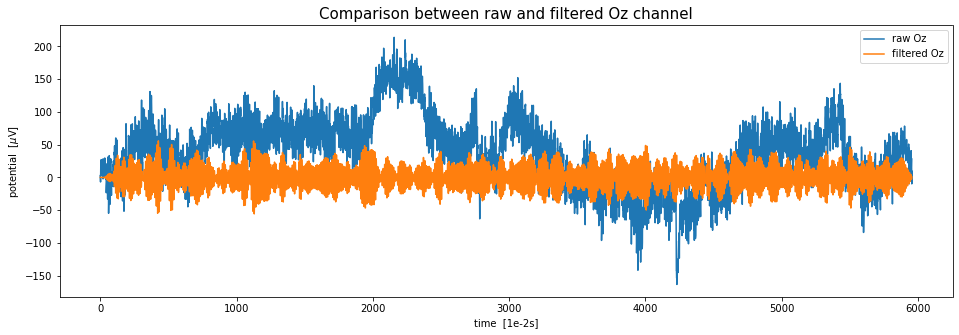

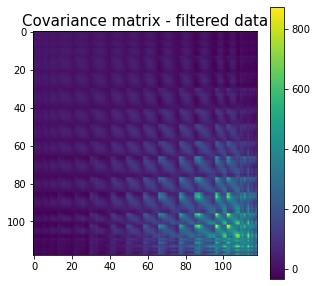

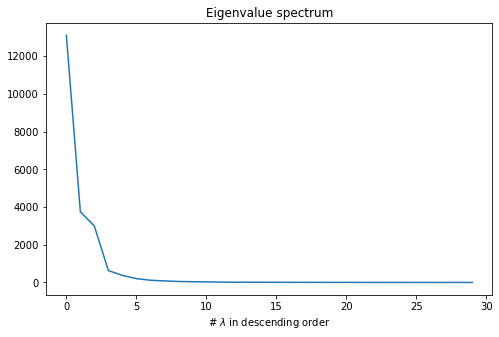

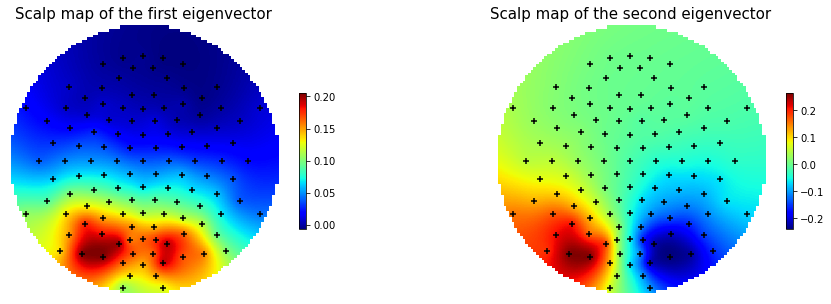

In [10]:
butter_filter = sp.signal.butter(10, [8,12], 'bandpass', fs = 100)
b,a = butter_filter
filtered_data = sp.signal.lfilter(b,a, X)

plt.figure(figsize = (16,5))
plt.plot(X[112], label = "raw Oz")
plt.plot(filtered_data[112], label = "filtered Oz")
plt.legend()
plt.xlabel('time  [1e-2s]')
plt.title("Comparison between raw and filtered Oz channel", fontsize = 15)
plt.ylabel('potential  [$\mu$V]');


cov_filtered = np.cov(filtered_data)

plt.figure(figsize = (5,5))
plt.imshow(cov_filtered)
plt.colorbar()
plt.title("Covariance matrix - filtered data", fontsize = 15);

eigval_filtered, eigvec_filtered = np.linalg.eigh(cov_filtered)
plt.figure(figsize = (8,5))
plt.plot(eigval_filtered[::-1][:30])
plt.title("Eigenvalue spectrum")
plt.xlabel("# $\lambda$ in descending order");

fig = plt.figure(figsize = (16,5))

fig.add_subplot(121)
plt.title("Scalp map of the first eigenvector", fontsize = 15)
bci.scalpmap(mnt,eigvec_filtered.T[-1])

fig.add_subplot(122)
plt.title("Scalp map of the second eigenvector", fontsize = 15)
bci.scalpmap(mnt,eigvec_filtered.T[-2])

If we compare the covariance matrix from exercise 1 to the covariance matrix of the filtered data, we can see that the first has bigger correlations between the first channels, while the second has bigger correlations in the last channels. By looking at the scalp map, we also see that the first case refers to more activity in the frontal lobe and the second refers to more activity in the occipital lobe.

## Exercise 4: Reconstruction with few PCs  (2 points)
Calculate the signals corresponding to the strongest principal components (second part of Ex. \#03) of the filtered data (project EEG data onto the PCs, i.e. go from *sensor space* to *source space*). Then reconstruct the EEG data from those strong principal components, i.e. project the signals obtained in the first step back into *sensor space*. Compare the band-pass filtered signal with the reconstructed signal in channel Oz. For plotting, the first six seconds are enough. You can also apply an error measure on your choice.

The mean squared error is:  0.39036056793481627


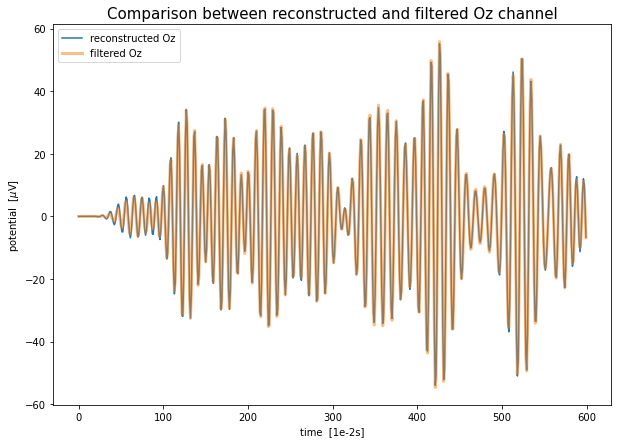

In [11]:
'''
From the eigenvalues spectrum, we can see that the first 5 to 10 eigenvectors still 
have some high associated eigenvectors, so for completeness, we take the first 10 principal 
components to reconstruct
'''
pcs_filtered = eigvec_filtered.T[-10:].T

#backward model
sources_filtered = pcs_filtered.T @ filtered_data

#forward model
recons_x_filtered = pcs_filtered @ sources_filtered

plt.figure(figsize = (10,7))
plt.plot(recons_x_filtered[112][:600], label = "reconstructed Oz")
plt.plot(filtered_data[112][:600], label = "filtered Oz", alpha = 0.5, linewidth = 3)
plt.legend()
plt.xlabel('time  [1e-2s]')
plt.title("Comparison between reconstructed and filtered Oz channel", fontsize = 15)
plt.ylabel('potential  [$\mu$V]');

MSE_error = (np.square(recons_x_filtered[112] - filtered_data[112])).mean()
print("The mean squared error is: ", MSE_error)